In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect= True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

# need column names
inspector = inspect(engine)
measureCols = inspector.get_columns("measurement")
for i in measureCols:
    print(i["name"], i["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
stationCols = inspector.get_columns("station")
for i in stationCols:
    print(i["name"],i["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
#most recent date is query the date; sort in descending order and pick first; in string fomat so still filters chronologically
mostRecentDate = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

mostRecentDate

('2017-08-23',)

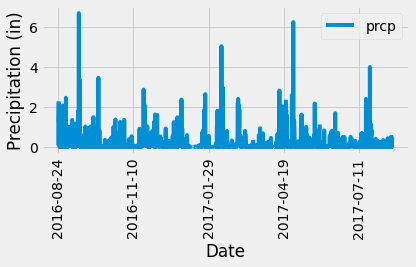

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
 
# To get last 12 months use all dates greater than one 1 year before most_recent_date
lastYear = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()


# create df
df = pd.DataFrame(lastYear)

# set index
df2 = df.set_index("date")


# # Use Pandas Plotting with Matplotlib to plot the data
df2.plot()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.tight_layout()
plt.show()



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stationsDF= session.query(Station.station).count()
stationsDF

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active = session.query(Measurement.station,func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).all() 

active 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# most active df
mostActiveDF = session.query(Measurement.station,func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).first()

# first value from the list will be most active station 
mostActiveStation = mostActiveDF[0]
mostActiveStation 

# lowest temperature
low = session.query(func.min(Measurement.tobs)).\
  filter(Measurement.station==mostActiveStation).all()

# highest temperature
high = session.query(func.max(Measurement.tobs)).\
  filter(Measurement.station==mostActiveStation).all()

# averaage temperature
average = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==mostActiveStation).all()

print(f'The lowest temp is {low}, The highest temp is {high}, and The average temp is {average}')

The lowest temp is [(54.0,)], The highest temp is [(85.0,)], and The average temp is [(71.66378066378067,)]


(0.0, 70.0)

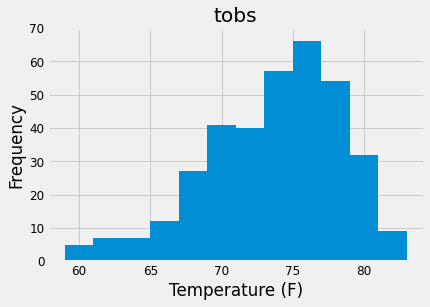

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


mostRecentDate = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == mostActiveStation).\
    order_by(Measurement.date.desc()).first()


# the most recent date was 2017-08-18
last12months = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == mostActiveStation).\
    filter(Measurement.date > '2016-08-17').all()

# Plot

# create df
last12monthsdf = pd.DataFrame(last12months)
last12monthsdf 

graph = last12monthsdf.hist(bins=12) 
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)


# Close session

In [18]:
# Close Session
session.close()